In [1]:
#!/usr/bin/env python3
import subprocess
import re
import csv

# Regex patterns (max 4 words per comment)
pat_cpu_vam = re.compile(r"CPU VAM solver completed in ([0-9.]+) seconds")
pat_gpu_vam = re.compile(r"GPU VAM solver completed in ([0-9.]+) seconds")
pat_cpu_lcm = re.compile(r"CPU LCM solver completed in ([0-9.]+) seconds")
pat_gpu_lcm = re.compile(r"GPU LCM solver completed in ([0-9.]+) seconds")
pat_cpu_modi = re.compile(r"CPU MODI solver completed in ([0-9.]+) seconds")
pat_gpu_modi = re.compile(r"Phase 2 optimization \(GPU MODI\) in:\s*([0-9.]+) seconds")
pat_cpu_ssm  = re.compile(r"Accelerated CPU SSM solver completed in ([0-9.]+) seconds")
pat_gpu_ssm  = re.compile(r"Phase 2 optimization \(GPU SSM\) in:\s*([0-9.]+) seconds")

# Run TPSolver and capture output
def run_tpsolver(supply, demand, seed=42):
    # Prepare input (seed, supply, demand)
    input_str = f"{seed}\n{supply}\n{demand}\n"
    # Call TPSolver executable
    proc = subprocess.run(["./TPSolver"], input=input_str.encode(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output = proc.stdout.decode()
    return output

# Parse output to get times
def parse_times(output):
    times = {}
    m = pat_cpu_vam.search(output)
    times["cpu_vam"] = float(m.group(1)) if m else None

    m = pat_gpu_vam.search(output)
    times["gpu_vam"] = float(m.group(1)) if m else None

    m = pat_cpu_lcm.search(output)
    times["cpu_lcm"] = float(m.group(1)) if m else None

    m = pat_gpu_lcm.search(output)
    times["gpu_lcm"] = float(m.group(1)) if m else None

    m = pat_cpu_modi.search(output)
    times["cpu_modi"] = float(m.group(1)) if m else None

    m = pat_gpu_modi.search(output)
    times["gpu_modi"] = float(m.group(1)) if m else None

    m = pat_cpu_ssm.search(output)
    times["cpu_ssm"] = float(m.group(1)) if m else None

    m = pat_gpu_ssm.search(output)
    times["gpu_ssm"] = float(m.group(1)) if m else None

    return times

# Gridsearch dimensions
results = []
for dim in range(10, 101, 10):
    print(f"Running {dim}x{dim}...")
    out = run_tpsolver(dim, dim, seed=42)
    t = parse_times(out)
    # Save dim and times
    results.append({
        "Supply": dim,
        "Demand": dim,
        "CPU VAM": t.get("cpu_vam"),
        "GPU VAM": t.get("gpu_vam"),
        "CPU LCM": t.get("cpu_lcm"),
        "GPU LCM": t.get("gpu_lcm"),
        "CPU MODI": t.get("cpu_modi"),
        "GPU MODI": t.get("gpu_modi"),
        "CPU SSM": t.get("cpu_ssm"),
        "GPU SSM": t.get("gpu_ssm")
    })

# Write to CSV
with open("results.csv", "w", newline="") as csvfile:
    fieldnames = ["Supply", "Demand", "CPU VAM", "GPU VAM", "CPU LCM", "GPU LCM", "CPU MODI", "GPU MODI", "CPU SSM", "GPU SSM"]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for row in results:
        writer.writerow(row)

print("Gridsearch complete. Results written to results.csv")

Running 10x10...
Running 20x20...
Running 30x30...
Running 40x40...
Running 50x50...
Running 60x60...
Running 70x70...
Running 80x80...
Running 90x90...
Running 100x100...
Gridsearch complete. Results written to results.csv


In [6]:
#!/usr/bin/env python3
import subprocess
import re
import csv

# Run TPSolver and capture output.
def run_TPSolver(seed, supply, demand, mode):
    # Build the input string
    # The TPSolver expects 4 lines: seed, supply, demand, mode
    inp = f"{seed}\n{supply}\n{demand}\n{mode}\n"
    try:
        result = subprocess.run(["./TPSolver"], input=inp, capture_output=True, text=True, check=True)
        return result.stdout
    except subprocess.CalledProcessError as e:
        print("Error running TPSolver:")
        print(e)
        return ""

# Parse the output to extract algorithm times.
def parse_times(output):
    # Look for "Times:" line and then the next 4 lines, each containing a key and time.
    times = {}
    lines = output.splitlines()
    found = False
    for idx, line in enumerate(lines):
        if line.strip().startswith("Times:"):
            found = True
            # Expect next 4 lines with timings
            for j in range(idx+1, idx+5):
                if j < len(lines):
                    # e.g., "VAM: 0.191193 sec"
                    m = re.search(r"(\w+):\s*([\d.]+)", lines[j])
                    if m:
                        key = m.group(1)
                        try:
                            value = float(m.group(2))
                        except:
                            value = None
                        times[key] = value
            break
    if not found or len(times) < 4:
        # Fall back: try matching all lines with pattern KEY: number sec
        for line in lines:
            m = re.search(r"^(VAM|LCM|MODI|SSM):\s*([\d.]+)", line)
            if m:
                times[m.group(1)] = float(m.group(2))
    return times

def main():
    seed = 42
    results = []  # Each result will be a dict with platform, supply, demand, and algorithm times.
    
    # CPU grid search: 20x20 to 100x100 in increments of 10, mode "0000"
    for size in range(20, 131, 10):
        print(f"CPU: {size}x{size}")
        out = run_TPSolver(seed, size, size, "0000")
        times = parse_times(out)
        result = {"platform": "CPU", "supply": size, "demand": size,
                  "VAM": times.get("VAM", ""),
                  "LCM": times.get("LCM", ""),
                  "MODI": times.get("MODI", ""),
                  "SSM": times.get("SSM", "")}
        results.append(result)
    
    # GPU grid search: 40x40 to 400x400 in increments of 40, mode "1111"
    for size in range(40, 481, 40):
        print(f"GPU: {size}x{size}")
        out = run_TPSolver(seed, size, size, "1111")
        times = parse_times(out)
        result = {"platform": "GPU", "supply": size, "demand": size,
                  "VAM": times.get("VAM", ""),
                  "LCM": times.get("LCM", ""),
                  "MODI": times.get("MODI", ""),
                  "SSM": times.get("SSM", "")}
        results.append(result)
    
    # Write results to CSV
    csvfile = "execution_times.csv"
    fieldnames = ["platform", "supply", "demand", "VAM", "LCM", "MODI", "SSM"]
    with open(csvfile, mode="w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        for r in results:
            writer.writerow(r)
    print(f"Results saved to {csvfile}")

if __name__ == "__main__":
    main()

CPU: 20x20
CPU: 30x30
CPU: 40x40
CPU: 50x50
CPU: 60x60
CPU: 70x70
CPU: 80x80
CPU: 90x90
CPU: 100x100
CPU: 110x110
CPU: 120x120
CPU: 130x130
GPU: 40x40
GPU: 80x80
GPU: 120x120
GPU: 160x160
GPU: 200x200
GPU: 240x240
GPU: 280x280
GPU: 320x320
GPU: 360x360
GPU: 400x400
GPU: 440x440
GPU: 480x480
Results saved to execution_times.csv


VAM on CPU: degree 4, SSE=4.860e-08, params=[6.22354866e-06 2.84308558e-06 1.05294683e-07 5.48271174e-13
 1.97989930e-11]
VAM on GPU: degree 4, SSE=1.181e-02, params=[4.63954544e-04 1.38028559e-03 9.73070679e-07 3.11757416e-23
 3.88374973e-27]
LCM on CPU: degree 4, SSE=3.862e-09, params=[2.18812439e-06 1.22000436e-08 3.13943073e-08 5.09655157e-10
 3.31380715e-12]
LCM on GPU: degree 1, SSE=2.951e-03, params=[0.0050572  0.00044967]
MODI on CPU: degree 4, SSE=1.074e-04, params=[6.70434641e-14 1.60302870e-32 2.40317199e-16 1.00600472e-08
 3.43189318e-10]
MODI on GPU: degree 2, SSE=4.879e+00, params=[1.88255778e-16 2.78596442e-03 3.94197442e-05]
SSM on CPU: degree 4, SSE=1.999e+02, params=[6.55699129e-17 1.34646054e-16 2.91500904e-16 6.62088713e-16
 3.45300645e-07]
SSM on GPU: degree 3, SSE=1.139e+02, params=[4.60654346e-13 2.71882522e-14 2.63145681e-04 2.28371761e-07]
For algorithm VAM, the intersection occurs at supply ≈ 446.81


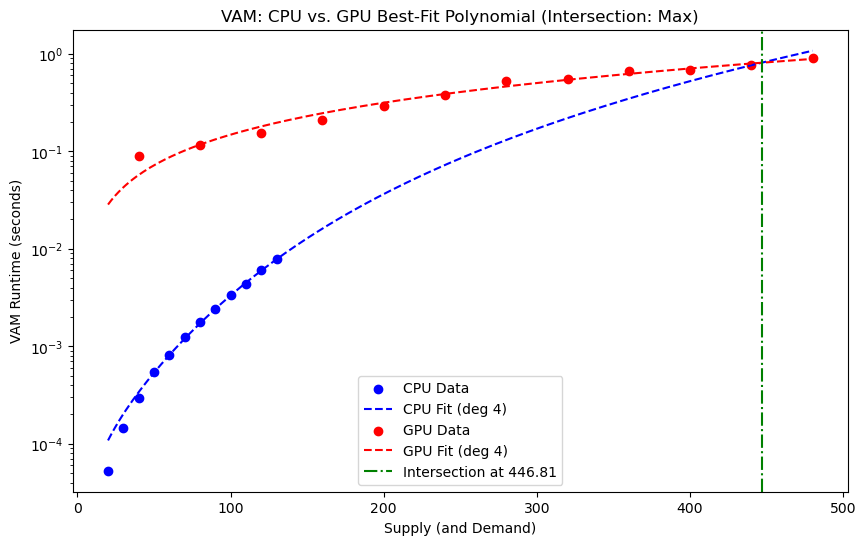

For algorithm LCM, the intersection occurs at supply ≈ 465.95


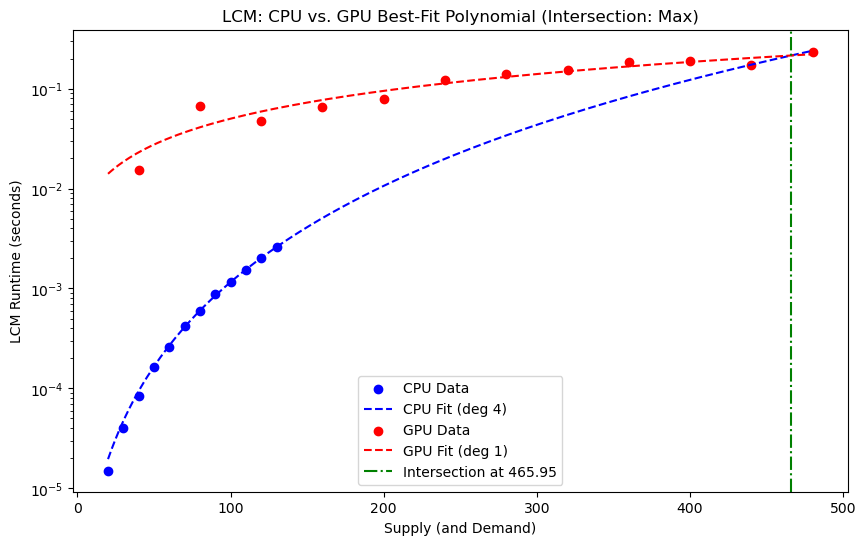

For algorithm MODI, the intersection occurs at supply ≈ 356.61


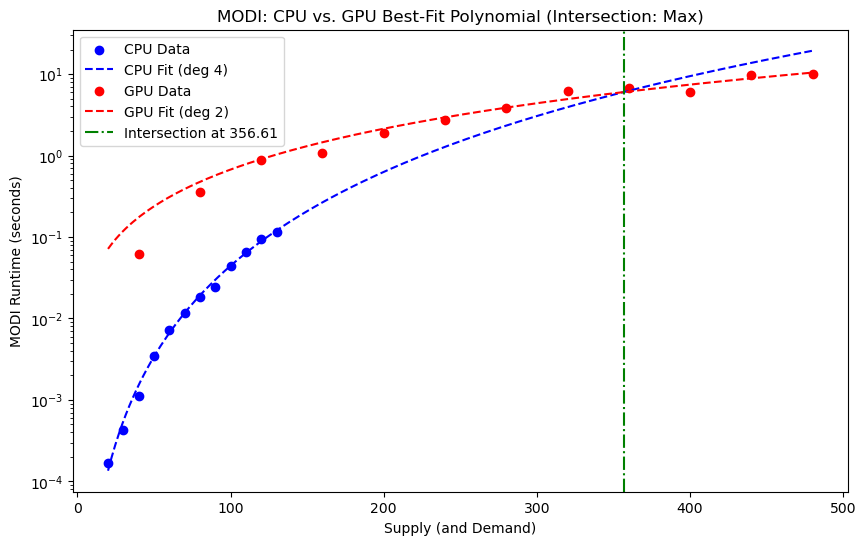

For algorithm SSM, the intersection occurs at supply ≈ 27.94


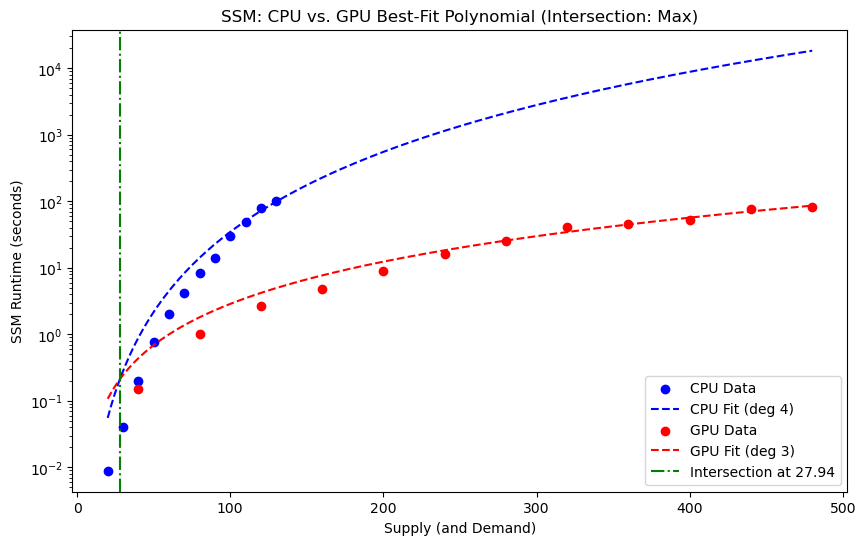

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Read the CSV file (adjust the path if needed)
df = pd.read_csv("execution_times.csv")

# We'll use the 'supply' column as the independent variable.
# (Assuming 'demand' is identical or very similar to 'supply'.)
# Split data by platform:
cpu_df = df[df['platform'] == 'CPU']
gpu_df = df[df['platform'] == 'GPU']

# Define our polynomial model function.
# Parameters are in ascending order (i.e. a0 + a1*x + a2*x^2 + ...).
def poly_func(x, *params):
    return sum(p * x**i for i, p in enumerate(params))

# Degrees to try: 1 through 4 (i.e. linear up to quartic)
degrees = [1, 2, 3, 4]
algorithms = ['VAM', 'LCM', 'MODI', 'SSM']

# This dictionary will store the best-fit results for each algorithm and each platform.
results = {algo: {} for algo in algorithms}

# A helper function to fit data for a given degree with nonnegative coefficient constraint.
def fit_polynomial(xdata, ydata, degree):
    # Number of parameters is degree+1; we force all parameters to be >= 0.
    bounds = (0, np.inf)
    # Initial guess: all ones.
    p0 = np.ones(degree + 1)
    params, _ = curve_fit(poly_func, xdata, ydata, p0=p0, bounds=bounds)
    # Compute the sum of squared errors (SSE).
    residuals = poly_func(xdata, *params) - ydata
    sse = np.sum(residuals**2)
    return params, sse

# For each algorithm and for each platform, try degrees 1-4.
for algo in algorithms:
    for platform, platform_df in [('CPU', cpu_df), ('GPU', gpu_df)]:
        xdata = platform_df['supply'].values
        ydata = platform_df[algo].values
        
        best_sse = np.inf
        best_params = None
        best_degree = None

        # Try polynomial degrees if there are at least degree+1 points.
        for deg in degrees:
            if len(xdata) < (deg + 1):
                continue  # not enough points for this degree
            try:
                params, sse = fit_polynomial(xdata, ydata, deg)
                # Only accept models where coefficients are positive.
                if np.all(params >= 0) and sse < best_sse:
                    best_sse = sse
                    best_params = params
                    best_degree = deg
            except Exception as e:
                print(f"Fit failed for {algo} on {platform} with degree {deg}: {e}")
                continue

        if best_params is None:
            print(f"No valid fit found for {algo} on {platform}")
        else:
            results[algo][platform] = {
                'degree': best_degree,
                'params': best_params,
                'sse': best_sse
            }
            print(f"{algo} on {platform}: degree {best_degree}, SSE={best_sse:.3e}, params={best_params}")

# For each algorithm, compute the intersection between the best-fit curves for CPU and GPU.
for algo in algorithms:
    if 'CPU' not in results[algo] or 'GPU' not in results[algo]:
        print(f"Skipping intersection for {algo} due to missing platform fits.")
        continue

    # Our curve_fit outputs parameters in order: [a0, a1, a2, ...]
    # np.poly1d expects coefficients with highest power first.
    cpu_params = results[algo]['CPU']['params'][::-1]
    gpu_params = results[algo]['GPU']['params'][::-1]
    
    cpu_poly = np.poly1d(cpu_params)
    gpu_poly = np.poly1d(gpu_params)
    
    # Create the difference polynomial: cpu_poly(x) - gpu_poly(x) = 0 when they intersect.
    diff_poly = cpu_poly - gpu_poly
    roots = diff_poly.r

    # Filter for positive, real roots.
    pos_real_roots = [r.real for r in roots if np.isreal(r) and r.real > 0]
    
    if pos_real_roots:
        # Instead of the smallest, choose the maximum positive intersection.
        intersection = max(pos_real_roots)
        print(f"For algorithm {algo}, the intersection occurs at supply ≈ {intersection:.2f}")
    else:
        intersection = None
        print(f"For algorithm {algo}, no positive real intersection was found.")

    results[algo]['intersection'] = intersection

    # Plot the results for this algorithm.
    plt.figure(figsize=(10, 6))
    x_range = np.linspace(df['supply'].min(), df['supply'].max(), 200)
    
    # Plot CPU data and fit.
    if 'CPU' in results[algo]:
        cpu_fit_values = cpu_poly(x_range)
        plt.scatter(cpu_df['supply'], cpu_df[algo], label='CPU Data', color='blue')
        plt.semilogy(x_range, cpu_fit_values, '--', label=f"CPU Fit (deg {results[algo]['CPU']['degree']})", color='blue')
    # Plot GPU data and fit.
    if 'GPU' in results[algo]:
        gpu_fit_values = gpu_poly(x_range)
        plt.scatter(gpu_df['supply'], gpu_df[algo], label='GPU Data', color='red')
        plt.semilogy(x_range, gpu_fit_values, '--', label=f"GPU Fit (deg {results[algo]['GPU']['degree']})", color='red')
    
    # Mark the intersection if available.
    if intersection is not None:
        plt.axvline(x=intersection, color='green', linestyle='-.', label=f"Intersection at {intersection:.2f}")
    
    plt.xlabel("Supply (and Demand)")
    plt.ylabel(f"{algo} Runtime (seconds)")
    plt.title(f"{algo}: CPU vs. GPU Best-Fit Polynomial (Intersection: Max)")
    plt.legend()
    plt.show()
